1) Проанализируйте переменные (столбцы) и укажите, для каких из них определение
числовых характеристик имеет смысл. Понимать значения всех характеристик, которые дает метод describe().

In [1]:
"Date, Seasons, Holiday, Functioning Day, Temperature Category"

'Date, Seasons, Holiday, Functioning Day, Temperature Category'

2) Для каждого сезона найдите: среднюю, медианную и модовую температуры, дисперсию, среднеквадратичное отклонение, размах и интерквартильный размах
температуры. Результат также выведите в виде общей таблицы.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

bikes_df = pd.read_csv("DataBikes_new.csv", sep=',')
bikes_df.columns = bikes_df.columns.str.strip()

seasons_groupby = bikes_df.groupby('Seasons')['Temperature']

bikes_num_desc_df= pd.DataFrame(
    {
        "mean": seasons_groupby.mean(),
        "median": seasons_groupby.median(),
        "mode": seasons_groupby.apply(
            lambda x: x.mode().iloc[0] if not x.mode().empty else None
        ),
        "variance": seasons_groupby.var(),
        "std": seasons_groupby.std().round(3),
        "range": seasons_groupby.max() - seasons_groupby.min(),
        "IQR": seasons_groupby.quantile(0.75) - seasons_groupby.quantile(0.25),
    }
)

display(bikes_num_desc_df)
seasons_groupby.describe()

,mean,median,mode,variance,std,range,IQR
Seasons,,,,,,,
Autumn,14.138821,13.8,10.8,49.589573,7.042,33.5,11.1
Spring,13.038533,13.3,9.6,43.665630,6.608,36.0,9.9
Summer,26.574827,26.6,23.4,21.655814,4.654,23.1,6.7
Winter,-2.567783,-2.2,-1.8,29.877730,5.466,28.1,7.7


,count,mean,std,min,25%,50%,75%,max
Seasons,,,,,,,,
Autumn,2138.0,14.138821,7.041986,-3.0,8.7,13.8,19.8,30.5
Spring,2154.0,13.038533,6.607997,-6.6,8.2,13.3,18.1,29.4
Summer,2169.0,26.574827,4.653581,16.3,23.1,26.6,29.8,39.4
Winter,2120.0,-2.567783,5.466052,-17.8,-6.2,-2.2,1.5,10.3


3) Переменная «Temperature» содержит None значения. Предложите и реализуйте способ их замены, который по Вашему мнению будет наиболее достоверно соответствовать
реальным условиям. Определите, как изменятся при этом числовые характеристики
среднего и разброса для температуры.

In [3]:
display(bikes_df['Temperature'].isna().sum())

stats_before = seasons_groupby.agg(['mean', 'std', 'var'])
display(stats_before)

bikes_df['Temperature'] = seasons_groupby.transform(lambda temps: temps.fillna(temps.median()))


seasons_groupby_new = bikes_df.groupby('Seasons')['Temperature']
stats_after = seasons_groupby_new.agg(['mean', 'std', 'var'])
display(bikes_df['Temperature'].isna().sum())
display(stats_after)

diff = stats_after - stats_before

display(diff)


np.int64(179)

,mean,std,var
Seasons,,,
Autumn,14.138821,7.041986,49.589573
Spring,13.038533,6.607997,43.665630
Summer,26.574827,4.653581,21.655814
Winter,-2.567783,5.466052,29.877730


np.int64(0)

,mean,std,var
Seasons,,,
Autumn,14.131685,6.967567,48.546994
Spring,13.044928,6.526781,42.598869
Summer,26.575272,4.612282,21.273144
Winter,-2.560972,5.415408,29.326642


,mean,std,var
Seasons,,,
Autumn,-0.007136,-0.074419,-1.042579
Spring,0.006395,-0.081217,-1.066761
Summer,0.000445,-0.041299,-0.382670
Winter,0.006811,-0.050645,-0.551088


4) Предположим, что наблюдения температуры, отклоняющиеся от средней температуры для каждого сезона более чем на два стандартных отклонения, являются выбросами.
Сформируйте таблицу без выбросов. Установить, будет ли наблюдаться отличие в характеристиках средних для температуры, построенных на основе исходной и новой
таблиц.

In [4]:
mean_col = seasons_groupby_new.transform('mean')
std_col = seasons_groupby_new.transform('std')

outliers_mask = bikes_df['Temperature'] > mean_col + 2*std_col
bikes_df_no_outliers = bikes_df[~outliers_mask].copy()

display(f"Count diff: {len(bikes_df)- len(bikes_df_no_outliers)}")
display(f"Mean diff: {bikes_df['Temperature'].mean() - bikes_df_no_outliers['Temperature'].mean()}")
display(f"Std diff: {bikes_df['Temperature'].std() - bikes_df_no_outliers['Temperature'].std()}")

'Count diff: 110'

'Mean diff: 0.2319068941853395'

'Std diff: 0.14028110980783026'

5) На одном графике построить размах для каждого месяца. Подписать название графика и его оси.

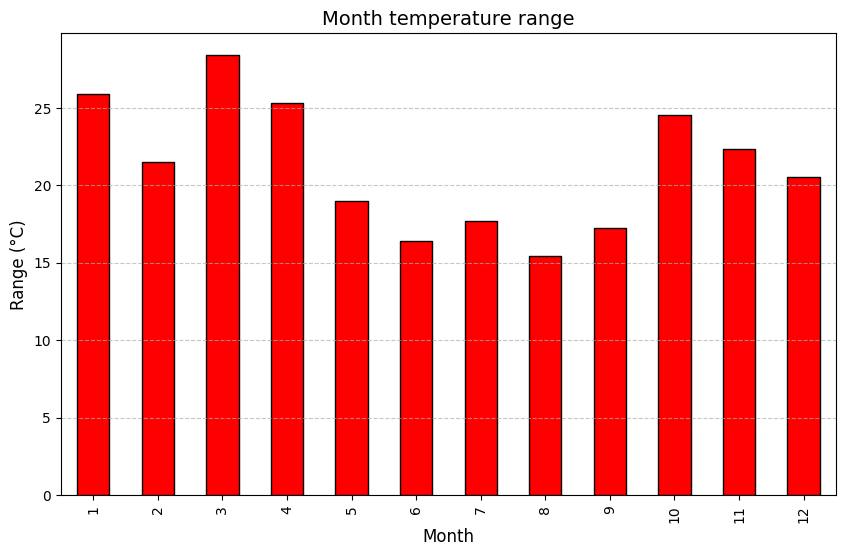

In [5]:
bikes_df_no_outliers['Date'] = pd.to_datetime(bikes_df_no_outliers['Date'], dayfirst=True)
bikes_df_no_outliers['Month'] = bikes_df_no_outliers['Date'].dt.month

month_range = bikes_df_no_outliers.groupby('Month')['Temperature'].apply(lambda x: x.max() - x.min())
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

month_range.plot(kind='bar', color='red', edgecolor='black')

plt.title('Month temperature range', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Range (°C)', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

6) Найдите, сколько дней работа проката по оценкам была выше среднего. В этом случае следует учитывать, что оценки выставлялись по разным шкалам, поэтому 10 по одной
шкале это отлично, а по другой очень плохо. Для решения этой проблемы используют так называемую «z-стандартизацию», т. е. вводят новую переменную z = (x - m) / sigma,
которая показывает на сколько среднеквадратичных отклонений, x отклоняется от среднего.

In [6]:
score_means = bikes_df_no_outliers.groupby('score_type')['score'].transform('mean')
score_stds = bikes_df_no_outliers.groupby('score_type')['score'].transform('std')

bikes_df_no_outliers['Z_score'] = (bikes_df_no_outliers['score'] - score_means) / score_stds
days_above_average = bikes_df_no_outliers[bikes_df_no_outliers['Z_score'] > 0]

display(f"Days above avg count: {len(days_above_average)}")

'Days above avg count: 4557'

7) Установить наличие линейной зависимости между температурой и числом арендованных велосипедов (по данным за весь год, по сезонам, по месяцам). Для данных,
имеющих максимальную линейную зависимость, построить график рассеяния.

'Корреляция за год: 0.455'

'Корреляция по сезонам'

Seasons
Autumn    0.241575
Spring    0.450014
Summer    0.157303
Winter    0.286557
Name: Rental count, dtype: float64

'Корреляция по месяцам'

Month
1     0.297647
2     0.377087
3     0.428640
4     0.503106
5     0.346402
6     0.382563
7     0.276595
8     0.205370
9     0.373702
10    0.210126
11    0.106616
12    0.166429
Name: Rental count, dtype: float64

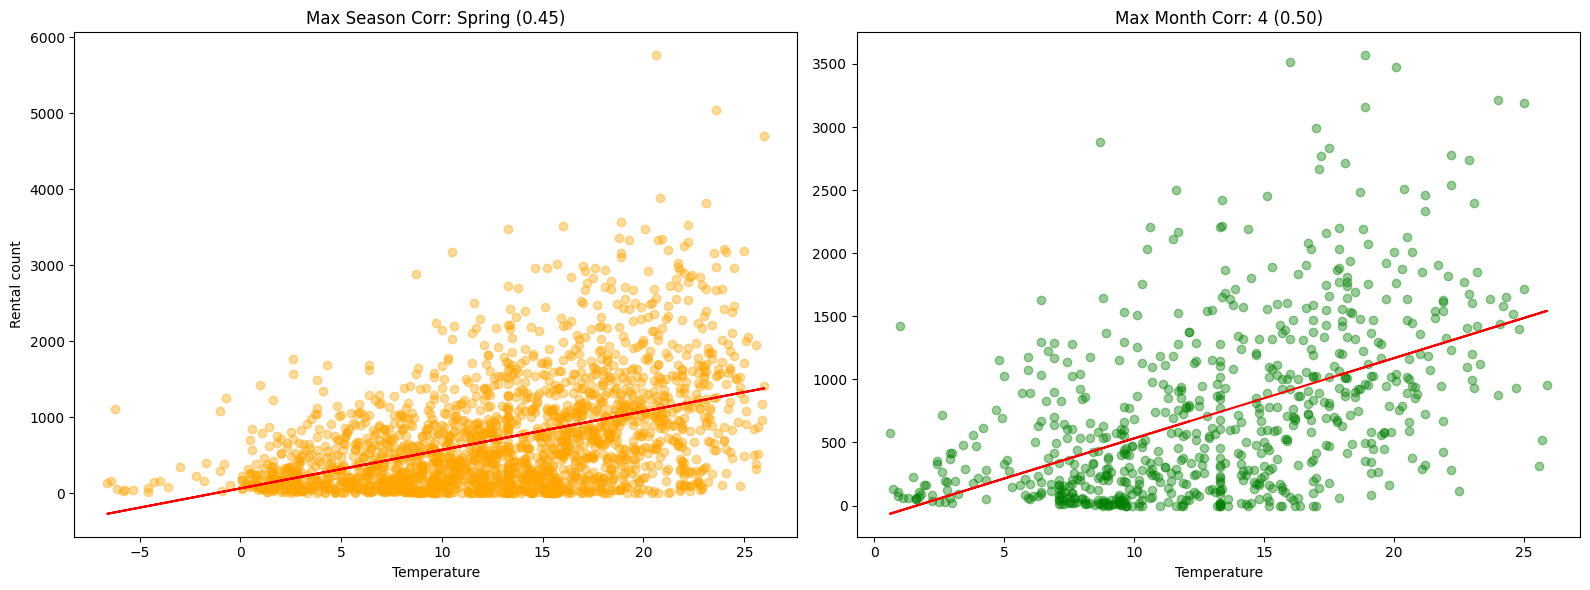

In [15]:
import numpy as np


corr_year = bikes_df_no_outliers['Temperature'].corr(bikes_df_no_outliers['Rental count'])
corr_seasons = bikes_df_no_outliers.groupby('Seasons')[['Temperature', 'Rental count']].corr().iloc[0::2, 1].reset_index(level=1, drop=True)
corr_months = bikes_df_no_outliers.groupby('Month')[['Temperature', 'Rental count']].corr().iloc[0::2, 1].reset_index(level=1, drop=True)

display(f"Корреляция за год: {corr_year:.3f}")
display("Корреляция по сезонам", corr_seasons)
display("Корреляция по месяцам", corr_months)

best_season = corr_seasons.idxmax()
best_month = corr_months.idxmax()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

season_data = bikes_df_no_outliers[bikes_df_no_outliers['Seasons'] == best_season]
ax[0].scatter(season_data['Temperature'], season_data['Rental count'], alpha=0.4, color='orange')
m1, b1 = np.polyfit(season_data['Temperature'], season_data['Rental count'], 1)
ax[0].plot(season_data['Temperature'], m1*season_data['Temperature'] + b1, color='red')
ax[0].set_title(f'Max Season Corr: {best_season} ({corr_seasons.max():.2f})')
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel('Rental count')

# График для лучшего МЕСЯЦА
month_data = bikes_df_no_outliers[bikes_df_no_outliers['Month'] == best_month]
ax[1].scatter(month_data['Temperature'], month_data['Rental count'], alpha=0.4, color='green')
m2, b2 = np.polyfit(month_data['Temperature'], month_data['Rental count'], 1)
ax[1].plot(month_data['Temperature'], m2*month_data['Temperature'] + b2, color='red')
ax[1].set_title(f'Max Month Corr: {best_month} ({corr_months.max():.2f})')
ax[1].set_xlabel('Temperature')

plt.tight_layout()
plt.show()

8) Аналогичные п.7 исследования провести для температуры и оценки.

Корреляция (Temp vs Score) за год: -0.011

Корреляция по сезонам:
 Seasons
Autumn   -0.012503
Spring    0.012010
Summer    0.018140
Winter   -0.060377
Name: score, dtype: float64

Корреляция по месяцам (топ-5):
 Month
5     0.078771
8     0.049624
9     0.026497
10   -0.006231
4    -0.006694
Name: score, dtype: float64


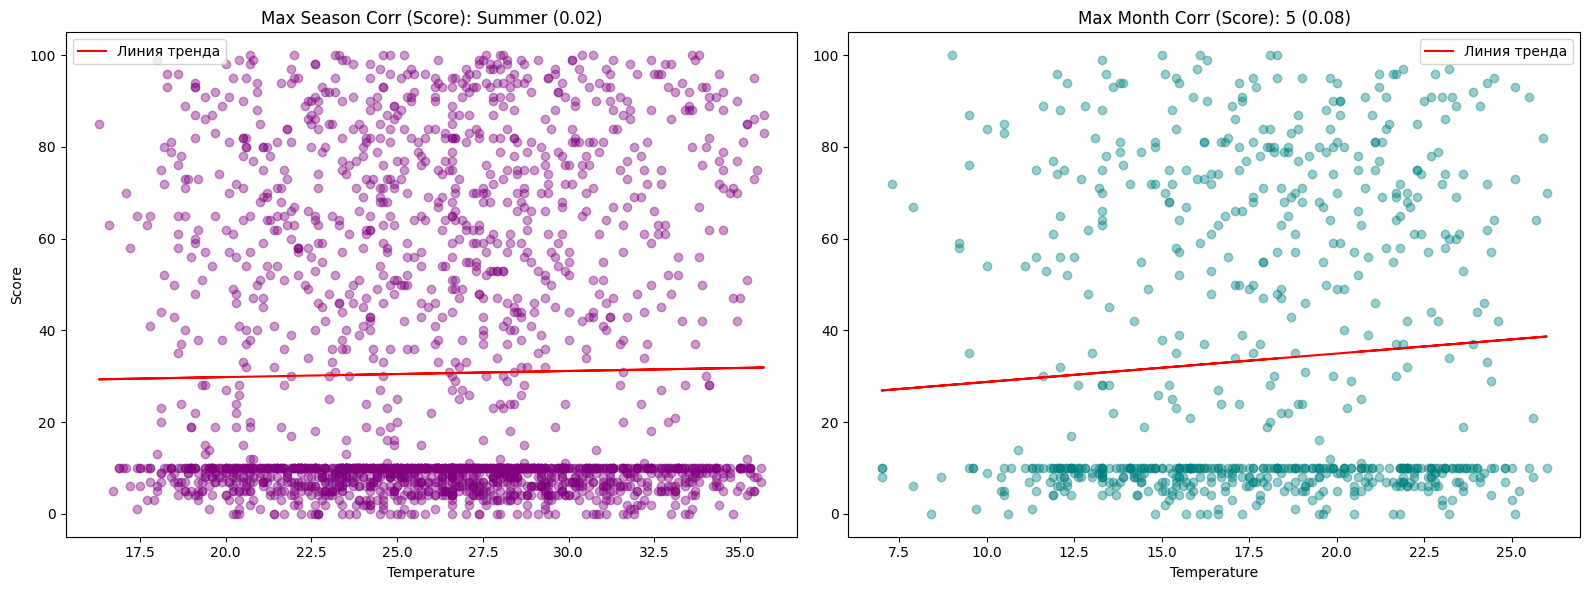

In [ ]:
corr_year_score = bikes_df_no_outliers['Temperature'].corr(bikes_df_no_outliers['score'])
corr_seasons_score = bikes_df_no_outliers.groupby('Seasons')[['Temperature', 'score']].corr().iloc[0::2, 1].reset_index(level=1, drop=True)
corr_months_score = bikes_df_no_outliers.groupby('Month')[['Temperature', 'score']].corr().iloc[0::2, 1].reset_index(level=1, drop=True)

print(f"Корреляция (Temp vs Score) за год: {corr_year_score:.3f}")
print("\nКорреляция по сезонам:\n", corr_seasons_score)
print("\nКорреляция по месяцам (топ-5):\n", corr_months_score.sort_values(ascending=False).head())

best_season_s = corr_seasons_score.idxmax()
best_month_s = corr_months_score.idxmax()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

season_data_s = bikes_df_no_outliers[bikes_df_no_outliers['Seasons'] == best_season_s]
ax[0].scatter(season_data_s['Temperature'], season_data_s['score'], alpha=0.4, color='purple')
m1, b1 = np.polyfit(season_data_s['Temperature'], season_data_s['score'], 1)
ax[0].plot(season_data_s['Temperature'], m1*season_data_s['Temperature'] + b1, color='red', label='Линия тренда')
ax[0].set_title(f'Max Season Corr (Score): {best_season_s} ({corr_seasons_score.max():.2f})')
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel('Score')
ax[0].legend()

month_data_s = bikes_df_no_outliers[bikes_df_no_outliers['Month'] == best_month_s]
ax[1].scatter(month_data_s['Temperature'], month_data_s['score'], alpha=0.4, color='teal')
m2, b2 = np.polyfit(month_data_s['Temperature'], month_data_s['score'], 1)
ax[1].plot(month_data_s['Temperature'], m2*month_data_s['Temperature'] + b2, color='red', label='Линия тренда')
ax[1].set_title(f'Max Month Corr (Score): {best_month_s} ({corr_months_score.max():.2f})')
ax[1].set_xlabel('Temperature')
ax[1].legend()

plt.tight_layout()
plt.show()